# Cross Correlation Analysis with Transmission Spectroscopy on WASP-121b
Welcome to this tutorial on high-resolution cross-correlation spectroscopy of exoplanets. Some parts of this tutorial are adopted from ESO workshop on 08/23/2021.

This tutorial covers how to cross correlate your high resolution data with forward model templates using POSEIDON. We will reproduce the result from [Gibson et al. 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.4618G/abstract), showing a strong Fe detection on WASP-121b using cross-correlation.

You should run this tutorial before running the transmission high resolution retrieval tutorial notebook, where we will demonstrate how to set up a high-resolution retrieval.

Although focused on transit transmission spectroscopy in the optical, these concepts also apply to day-side emission spectra and infrared wavelengths. See emission_cross_correlate.ipynb to learn more.


### We'll make use of:

* Spectral orders extracted and processed as desribed in [Gibson et al. 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.4618G/abstract).
* Wavelength solutions.
* The orbital phases of the time series.
* The line-of-sight velocity of Earth with respect to the barycenter during the time series (barycenteric velocity). We don't have to worry about it in this dataset because we have shifted the data into the rest frame of the barycenter.
* POSEIDON's forward model.

![title](../../_static/notebook_images/high-res-trans.png)

The Earth's transmission spectrum longward of 1 micron becomes severely affected by the absorption of molecular species in our own atmosphere, primarily water vapour (H<sub>2</sub>O), but also methane (CH<sub>4</sub>) and carbon dioxide (CO<sub>2</sub>). An example of this can be seen in a model transmission spectrum calculated with the [ESO Sky Model Calculator](https://www.eso.org/observing/etc/bin/gen/form?INS.MODE=swspectr+INS.NAME=SKYCALC) (R=20,000, zenith, 2.5 mm of precipitable water vapour, average yearly conditions at Cerro Paranal).

![Earth's transsmission spectrum](../../_static/notebook_images/high_res_Earth_trans.gif)

Such dominance of telluric lines (telluric = "of the Earth") requires a different approach than for optical spectra. In the cell below, we read the raw data, remove outliers, applying blaze correction, fit uncertainties to the data according to Gibson et al. 2022, and finally apply Sysrem algorithm to extract the signals.

## Loading Data

First, we will load the high resolution data for your planet (WASP-121b in our case).

Your data should include
1. raw flux from the observation, This should be a 3D array: NOrders x NExposures x NPixels.
2. wavelength grid of your observations. This should be a 2D array: NOrders x Npixels.
3. orbital phase of each exposure. This should be a 1D array: NExposures.
4. transit weight of each exposure. The value should ne 1 before and after transit; transit depth in mid-transit. This should be a 1D array: NExposures.

Suppose this is the first time you use POSEIDON on this dataset. We will read the dataset in its raw form, processes it, and save it into POSEIDON compatibale format (.hdf5).

This example dataset can be downloaded from POSEIDON's reference data repoistory on Google Drive TODO.

In [ ]:
from POSEIDON.high_res import (
    remove_outliers,
    blaze_correction,
    fit_uncertainties,
    prepare_high_res_data,
    read_hdf5,
)

data_dir = "/home/rwang/final_experiments/data/WASP-121b/"
names = ["blue"] # only use blue arm for demo purposes
# Change to the line below to use both blue and red arms.
# names = ["blue", "redl", "redu"] 
# This is how you combine multiple datasets together.
# It could be different nights of observations or even data from different instruments.
# In this case, we are combining diffrrent arms of the same instrument.
# It is equivalent if you combine them together beforehand by yourself.

for i in range(len(names)):
    data_raw = read_hdf5(
        data_dir + names[i] + "/data_raw.hdf5"
    )
    flux = data_raw["flux"]
    wl_grid = data_raw["wl_grid"]
    phi = data_raw["phi"]
    tranist_weight = data_raw["transit_weight"]

    flux = remove_outliers(wl_grid, flux)
    flux = blaze_correction(flux, filter_size=(500, 100))
    uncertainties = fit_uncertainties(flux, n_components=5)
    prepare_high_res_data(
        data_dir,
        names[i],
        "transmission",
        "sysrem",
        flux,
        wl_grid,
        phi,
        uncertainties,
        tranist_weight,
        sysrem_niter=15
    )


2078 outliers removed from a total of 9302280 pixels
Blaze correcting data with median filter size 500 and gaussian filter size 100
Fitting Poisson uncertainties with 5 components
Creating processed data at /home/rwang/final_experiments/data/WASP-121b/blue/data_processed.hdf5
Filtering out systematics using SYSREM with 15 iterations
12998 outliers removed from a total of 11863020 pixels
Blaze correcting data with median filter size 500 and gaussian filter size 100
Fitting Poisson uncertainties with 5 components
Creating processed data at /home/rwang/final_experiments/data/WASP-121b/redl/data_processed.hdf5
Filtering out systematics using SYSREM with 15 iterations
18099 outliers removed from a total of 8210448 pixels
Blaze correcting data with median filter size 500 and gaussian filter size 100
Fitting Poisson uncertainties with 5 components
Creating processed data at /home/rwang/final_experiments/data/WASP-121b/redu/data_processed.hdf5
Filtering out systematics using SYSREM with 15 ite

In [23]:
from POSEIDON.high_res import read_high_res_data

data_dir = "/home/rwang/final_experiments/data/WASP-121b/" # use the directory where you stored the processed data
# names = ["blue", "redl", "redu"]
names = ["blue"]
data = read_high_res_data(data_dir, names=names)

Let's take a look at what the residual look like for order 15. Since the planet-to-star signal ratio is low, we can's see the planet signal by eye. The figure below is what the residuals would look like if the planet signal is enhanced.

![title](../../_static/notebook_images/high_res_residual_signal.png)

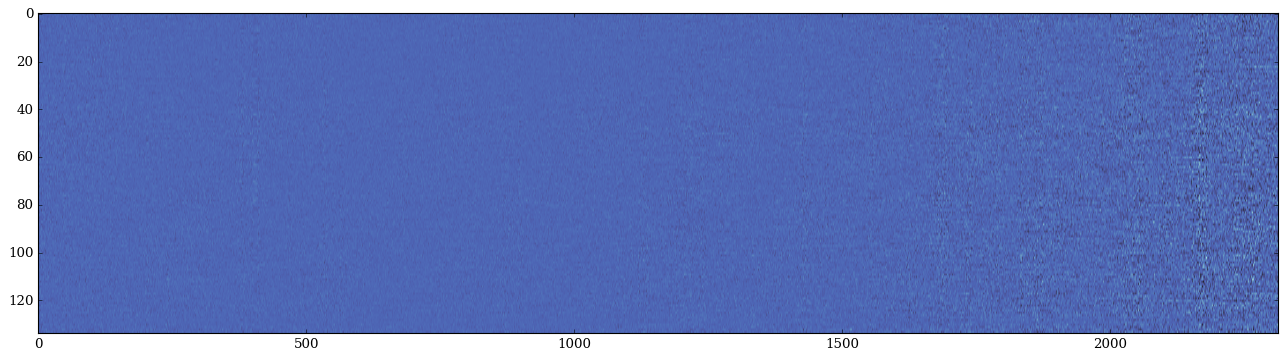

In [25]:
import matplotlib.pyplot as plt
import cmasher as cmr
plt.figure(figsize=(20, 5))
plt.imshow(data["blue"]["residuals"][15], aspect="auto", cmap=cmr.sapphire)

## Setting up forward model
Below, we are setting up POSEIDON's forward model. This includes specifying the the properties of the star-planet system, which chemical species we want to include, the resolution at which we calculate the model, and the temperature-pressure profile of our model atmosphere.

Here we set the spectral resolution to be R=250,000. This is a tradeoff betweem speed (also RAM) and accuracy. Because our high-dispersion data usally has R ≥ 25,000, empirically we want our model to be 10 times more refined than the data such that when binned down to data resolution, it retains high accuracy.

For tutorials on POSEDION's forward model, see transmission_basic.ipynb. For more advanced usage, (for example, including clouds in the atmosphere), see transmission_clouds.ipynb.

In [4]:
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import *
import numpy as np
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.constants import R_J, M_J
import numpy as np

R_s = 1.458 * R_Sun  # Stellar radius (m)
T_s = 6776  # Stellar effective temperature (K)
Met_s = 0.13  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.24  # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, stellar_grid="phoenix")

F_s = star["F_star"]
wl_s = star["wl_star"]

# ***** Define planet properties *****#

planet_name = "WASP-121b"  # Planet name used for plots, output files etc.

R_p = 0.118 * R_s  # Planetary radius (m)
M_p = 1.157 * M_J  # Mass of planet (kg)
g_p = 10 ** (2.97 - 2)  # Gravitational field of planet (m/s^2)
T_eq = 2450  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

from POSEIDON.core import define_model, wl_grid_constant_R, make_atmosphere

# ***** Define model *****#

model_name = "Fe"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
# param_species = ["Fe", "Cr", "Mg", "V"]
param_species = ["Fe"]

model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="isotherm",
    # cloud_model="MacMad17",
    # cloud_type="deck",
)

wl_min = 0.37  # Minimum wavelength (um)
wl_max = 0.87  # Maximum wavelength (um)
R = 250000  # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, stellar_grid="phoenix")

# ***** Read opacity data *****#

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 2900  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 3100  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -12.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
Fe done
Opacity pre-interpolation complete.


In [5]:
# Specify the pressure grid of the atmosphere
P_min = 1.0e-12  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-2  # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

log_species = [-5]
# log_species = [-5, -7, -4, -8]
T = 3000

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array([T])
log_X_params = np.array([log_species])
# cloud_params = np.array([0])

atmosphere = make_atmosphere(
    planet,
    model,
    P,
    P_ref,
    R_p_ref,
    PT_params,
    log_X_params,
)

# Generate planet surface flux
spectrum = compute_spectrum(
    planet,
    star,
    model,
    atmosphere,
    opac,
    wl,
    spectrum_type="transmission",
)

Let's take a look at the model spectrum we just calculated. The fisrt figure below shows the calculated spectrum at raw resolution R=250,000 and the spectrum binned down to data resolution. We can see forests of Fe lines in this wavelength range.

The second figure shows a spectrum binned down to R=1000. We see the line depths significantly decrease comparing to the model at raw resolution. This is why we can't do cross-correlation analysis at low resolution! Remember the correlation is directly proportional to the number of lines and the line depth.

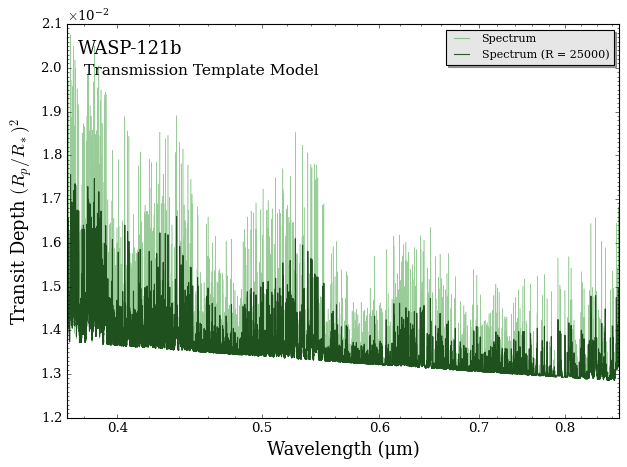

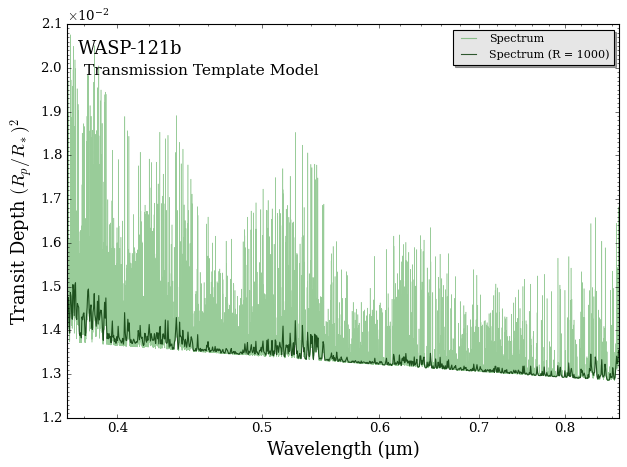

In [12]:
from scipy.ndimage import gaussian_filter1d, maximum_filter1d, minimum_filter1d
from POSEIDON.utility import plot_collection
from POSEIDON.visuals import plot_spectra

# Add the spectrum we want to plot to an empty spectra plot collection
spectra = plot_collection(spectrum, wl, collection = [])

fig = plot_spectra(spectra, planet, bin_spectra =True, R_to_bin=25000, plt_label = 'Transmission Template Model')
fig = plot_spectra(spectra, planet, bin_spectra =True, R_to_bin=1000, plt_label = 'Transmission Template Model')

## The cross-correlation function

Cross correlation has been used in various flavours since the first application in [Snellen et al. 2010](https://www.nature.com/articles/nature09111). In this example, we use the following definition:


$$
CCF(v,t) = \sum_i^N \frac{ f_i(t) m_i(v)}{\sigma_i^2}
$$

Here, $m_i$ is the template shifted to a radial velocity $v$. $f_i$ is the residual observed at time $t$. $m_i$ is now defined on the same grid as $f_i$ through interpolation. $C$ then is a 2-dimensional matrix, as function of time along the transit and the radial velocity shift of the template. At the correct combination of time and velocity, the signal of the planet should appear.

Let's cross-correlate our template model with the data!

In [ ]:
from scipy.ndimage import gaussian_filter1d, maximum_filter1d, minimum_filter1d

Kp_range = np.arange(-300, 301, 1)
Vsys_range = np.arange(-200, 201, 1)
RV_range = np.arange(-400, 401, 1)

CCF_Kp_Vsys_all = []
CCF_phase_RV_all = []
for key in data.keys():
    CCF_Kp_Vsys, CCF_phase_RV = cross_correlate(
        Kp_range,
        Vsys_range,
        RV_range,
        wl,
        # spectrum - gaussian_filter1d(minimum_filter1d(spectrum, 2000), 1000),
        spectrum,
        data[key],
    )
    CCF_Kp_Vsys_all.append(CCF_Kp_Vsys)
    CCF_phase_RV_all.append(CCF_phase_RV)
CCF_phase_RV_all = np.array(CCF_phase_RV_all)
CCF_Kp_Vsys_all = np.array(CCF_Kp_Vsys_all)

Cross correlation took 69.29411792755127 seconds


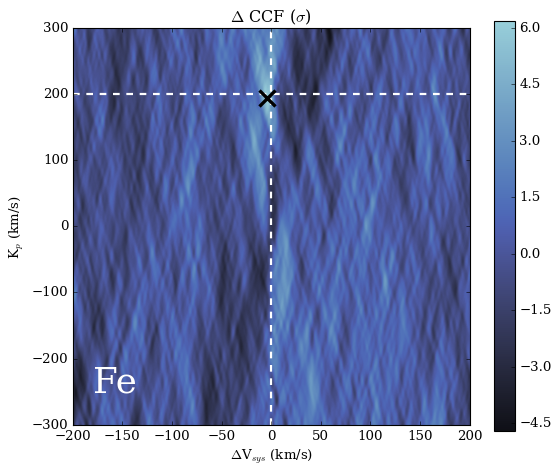

In [14]:
plot_CCF_Kp_Vsys(
    Kp_range,
    Vsys_range,
    np.sum(CCF_Kp_Vsys_all[:], axis=0),
    "Fe",
    200,
    Vsys=0,
    RM_mask_size=50,
    plot_label=True,
    plot_slice=False,
    cmap=cmr.get_sub_cmap("cmr.sapphire", 0.1, 0.9),
)

Cross correlation took 70.63011050224304 seconds


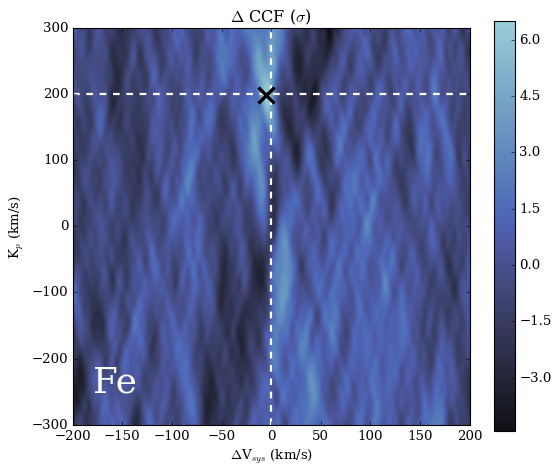

In [26]:

CCF_Kp_Vsys_all = []
CCF_phase_RV_all = []
for key in data.keys():
    CCF_Kp_Vsys, CCF_phase_RV = cross_correlate(
        Kp_range,
        Vsys_range,
        RV_range,
        wl,
        # spectrum - gaussian_filter1d(minimum_filter1d(spectrum, 2000), 1000),
        gaussian_filter1d(spectrum, 2),
        data[key],
    )
    CCF_Kp_Vsys_all.append(CCF_Kp_Vsys)
    CCF_phase_RV_all.append(CCF_phase_RV)
CCF_phase_RV_all = np.array(CCF_phase_RV_all)
CCF_Kp_Vsys_all = np.array(CCF_Kp_Vsys_all)
plot_CCF_Kp_Vsys(
    Kp_range,
    Vsys_range,
    np.sum(CCF_Kp_Vsys_all[:], axis=0),
    "Fe",
    200,
    Vsys=0,
    RM_mask_size=50,
    plot_label=True,
    plot_slice=False,
    cmap=cmr.get_sub_cmap("cmr.sapphire", 0.1, 0.9),
)

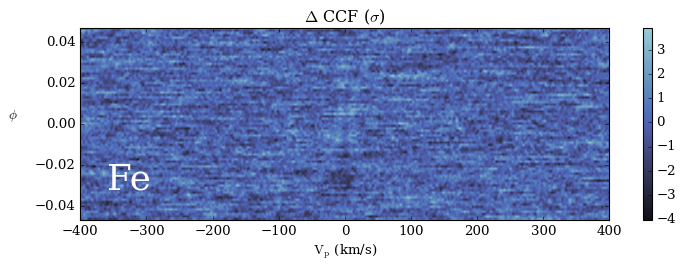

In [15]:
transit_model = data["blue"]["transit_weight"]
in_transit = transit_model != 1
phi = data["blue"]["phi"][in_transit]
plot_CCF_phase_RV(
    phi,
    RV_range,
    np.mean(CCF_phase_RV_all, axis=0)[in_transit],
    "Fe",
    plot_label=True,
    save_path=None,
    cmap=cmr.get_sub_cmap("cmr.sapphire", 0.1, 0.9),
)

If you see a signal to noise ratio around 6 in the first plot and no visible trail in the second plot, this is expected. There are several reasons the detection strength is less than what's reported in [Gibson et al. 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.4618G/abstract). After all, the template model in this tutorial is very simplified: isothermal at T=3000K, constant mixing ratio $\log_{10}(X_{Fe}) = -5$. We have not considered potential existence of clouds, nor have we used the red arm of the data (see comments in the first code cell). We have also arbitrarily used 15 iterations of Sysrem, and there are studies showing detection strength can be optimized on number of iterations.

If you have a high-resolution dataset in hand, feel free to experiment with how detection strength vary with different choices by modifying this notebook! And now that you have run through this tutorial, you are ready to move to transmission_high_res_retrieval.ipynb and run your retrievals! Note that the retrieval tutorial is ready to run once you've run the first cell and have data_processed.hdf5 saved.